# Large scale text analysis with deep learning

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0). 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  64.4M      0  0:00:01  0:00:01 --:--:--  156M
Train_rev1.csv


(244768, 12)

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

In [3]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


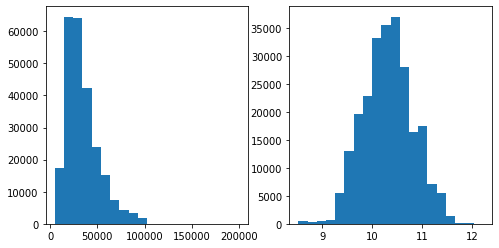

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
115269,69763084,Assistant / Deputy Manager,About The Company Earmarked as being THE RETAI...,Milton Keynes South East,Milton Keynes,full_time,NaN,Discover Retail,Retail Jobs,18000 - 23000,20500,discoverretail.co.uk,9.928229
78484,69015150,HR Advisor,HR Advisor sought by rapidly growing **** empl...,"Rotherhithe, London",Rotherhithe,NaN,permanent,Pinnacle Recruitment Selection,HR & Recruitment Jobs,25000 - 30000/annum 25000-30000,27500,cv-library.co.uk,10.221977
235229,72541306,QA Supervisor,QA Supervisor required for leading food produc...,"Huntingdon, Cambridgeshire",Huntingdon,NaN,permanent,PMP Solutions Ltd,Retail Jobs,26000 - 28000/annum benefits,27000,cv-library.co.uk,10.203629


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [7]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

# see task above
#<YOUR CODE HERE>
data["FullDescription"] = [ preprocess(string) for string in data["FullDescription"] ]
data['Title'] = [ preprocess(string) for string in data["Title"].astype(str) ]

Now we can assume that our text is a space-separated list of tokens:

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }

# token_counts = <YOUR CODE>

from nltk.tokenize import word_tokenize
nltk.download('punkt')

tokenized_words_fulldesc = ([word_tokenize(i) for i in data["FullDescription"]])
tokenized_words_title = ([word_tokenize(i) for i in data['Title']])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
tokenized_words = tokenized_words_fulldesc + tokenized_words_title 

In [11]:
import itertools
from collections import Counter

tokenized_words_flatt = list(itertools.chain(*tokenized_words))

token_counts = Counter(tokenized_words_flatt)

# hint: you may or may not want to use collections.Counter <- used this for the last homework and will use it here also

In [12]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

# assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 201923
('and', 2657388)
('.', 2567578)
(',', 2343362)
('the', 2080994)
('to', 2019884)
...
('improvemen', 1)
('techniciancivil', 1)
('mlnlycke', 1)
Correct!


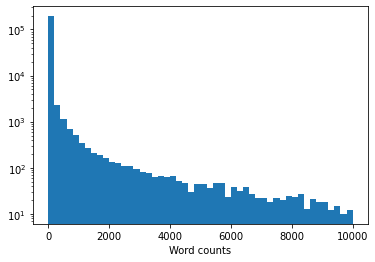

In [13]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Now filter tokens a list of all tokens that occur at least 10 times.

In [14]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
#tokens = <YOUR CODE HERE>

from itertools import dropwhile

for key, count in dropwhile(lambda key_count: key_count[1] >= min_count, token_counts.most_common()):
    del token_counts[key]
    
tokens = token_counts.keys()

In [15]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 33919
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [16]:
# token_to_id = <your code here>

token_to_id = dict(zip(tokens, range(len(tokens))))

In [17]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [18]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [19]:
print("Lines:")
print('\n'.join(data["Title"][::100100].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100100]))

Lines:
engineering systems analyst
technical administrator food
senior trading manager ambient

Matrix:
[[10581 29935  1941     1]
 [30238  1260 12335     1]
 [27419 31135 18638  1829]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [20]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [21]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [22]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [23]:
# let's see what we have 
make_batch(data_train[:3], max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[27419, 29667, 33448, 32713,   757, 27419, 29667, 33448, 16225,
         32713],
        [29013,    38, 18949, 19816, 15328, 22936,  3826, 25285,   738,
            10],
        [30520, 21730, 20375,  6183, 16225,  7939, 27267,   757, 30186,
         17520]], dtype=int32),
 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32),
 'Title': array([[27419, 29667, 33448,     1,     1,     1,     1],
        [29013,    38, 18949, 19816, 15328, 22936,  3826],
        [10383, 30186, 17520,     8,  8479, 28931,     9]], dtype=int32)}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use __[Keras Functional API](https://keras.io/models/model/)__.

In [70]:
import keras
import keras.layers as L

In [71]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
      
    # <YOUR CODE>
    # Build your monster!
    # spent so much time on this! then found a hint in the below text - conv1d should be used ;)

    # just simply coded what is written in the figure above without thinking too much
    x_title = L.Embedding(n_tokens, hid_size)(l_title)
    x_title = L.Conv1D(hid_size, kernel_size = 3)(x_title)
    x_title = L.GlobalMaxPooling1D()(x_title) # wasn't working without this
    x_title = L.Dense(hid_size, activation='relu')(x_title)
    
    x_descr = L.Embedding(n_tokens, hid_size)(l_descr)
    x_descr = L.Conv1D(hid_size, kernel_size = 3)(x_descr)
    x_descr = L.GlobalMaxPooling1D()(x_descr)
    x_descr = L.Dense(hid_size, activation='relu')(x_descr)
    
    x_categ = L.Dense(hid_size, activation='relu')(l_categ)
    
#     x_title = L.Dense(hid_size, activation='relu')(l_title)
#     x_descr = L.Dense(hid_size, activation='relu')(l_descr)
#     x_categ = L.Dense(hid_size, activation='relu')(l_categ)
    
    x = L.concatenate([x_title, x_descr, x_categ])
    
    x = L.Dense(hid_size, activation='relu')(x)
  
    output_layer = L.Dense(1, activation="relu")(x)
    # # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model
    

In [72]:
model = build_model()
model.summary()

### nice! this is working!

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
FullDescription (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, None, 64)     2170816     Title[0][0]                      
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, None, 64)     2170816     FullDescription[0][0]            
___________________________________________________________________________________________

In [73]:
dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [74]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [75]:
batch_size = 256
epochs = 20            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

# model = build_model()
build_model()

history_1 = model.fit(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

Epoch 1/20
100/100 [==============================] - 21s 203ms/step - loss: 17.4203 - mean_absolute_error: 2.5876 - val_loss: 0.3369 - val_mean_absolute_error: 0.4442
Epoch 2/20
100/100 [==============================] - 20s 197ms/step - loss: 0.2458 - mean_absolute_error: 0.3834 - val_loss: 0.1935 - val_mean_absolute_error: 0.3355
Epoch 3/20
100/100 [==============================] - 20s 199ms/step - loss: 0.1557 - mean_absolute_error: 0.3015 - val_loss: 0.1286 - val_mean_absolute_error: 0.2722
Epoch 4/20
100/100 [==============================] - 20s 199ms/step - loss: 0.1147 - mean_absolute_error: 0.2581 - val_loss: 0.0992 - val_mean_absolute_error: 0.2381
Epoch 5/20
100/100 [==============================] - 20s 198ms/step - loss: 0.0948 - mean_absolute_error: 0.2323 - val_loss: 0.0876 - val_mean_absolute_error: 0.2220
Epoch 6/20
100/100 [==============================] - 20s 200ms/step - loss: 0.0842 - mean_absolute_error: 0.2177 - val_loss: 0.0798 - val_mean_absolute_error: 0.21

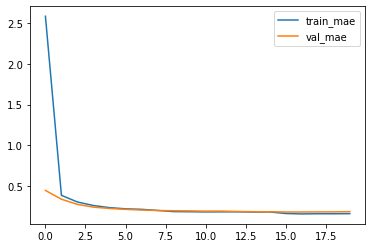

In [76]:
import matplotlib.pyplot as plt
 
plt.plot(history_1.history['mean_absolute_error'], label='train_mae')
plt.plot(history_1.history['val_mean_absolute_error'], label='val_mae')
plt.legend(loc="upper right")

In [77]:
# ok, seems that this works, 

def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
    
print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

Train results:
Mean square error: 0.03859
Mean absolute error: 0.14576
Val results:
Mean square error: 0.06097
Mean absolute error: 0.18276


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [78]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 

    *predictions_drop_one_token, baseline_pred = model.predict(make_batch(data_drop_one_token))[:, 0]
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))

In [79]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [80]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [81]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


cleaning operative

12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [82]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model.predict(make_batch(data.iloc[i: i+1]))[0, 0]))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 108151
Salary (gbp): 21287.46


hr project manager , banking

our client , a global , high profile bank , they have an exciting opportunity for a hr project manager to join them on a permanent basis as part of their internal hr consulting function , leading and delivering hr business change projects across all areas of the business . participation in complex , large scale , multiple dependency programmes of change across a number of business areas with the firm on a global basis . exposure to strategy , design and implementation of change across the hr functions on a global scale . end to end project management of various projects across hr , in all areas and disciplines . application of change management and control methods process reengineering and process analysis as required provide pmo support to the overall project inclusive of project logs , status reports , communication / project plans etc undertake business analysis , for process improvement projects provision of project management expertise , coaching and support for hr colleagues undertaking change activities . ensure projects are set up for success . working with the hr management team on an ongoing basis to agree key , strategic change projects and which projects will be prioritises / consolidated the successful candidate will have a strong hr background , ideally with some good previous project and change management experience gained within a complex , matrix environment . strong numeracy and analytical skills will be essential , though technical mi support is embedded . outstanding relationship management and communication skills are crucial as you will manage relationships and stakeholders at all levels , influence , coach and engage outcomes . consulting experience would be beneficial but is not essential . this job was originally posted as www . totaljobs . com / jobseeking / UNK ****

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)

## Final task: improve over it

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time - our `L.GlobalMaxPool1D`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not want to use __`.get_keras_embedding()`__ method for word2vec
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback](https://keras.io/api/callbacks/early_stopping/).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!

In [60]:
# let's play a bit with CNN architecture, adding 
# batch normalization
# droupout 
# (Global max pooling is already being used), 
# one more dense layer and co
# and apply several Conv1d to the same embeddings.
# so collect everything in one place

def build_model_2(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
      
    # <YOUR CODE>
    # Build your monster!
    
    x_title_embedding = L.Embedding(n_tokens, hid_size)(l_title)

    x_title_conv1 = L.Conv1D(hid_size, kernel_size = 3)(x_title_embedding)
    x_title_conv1 = L.BatchNormalization()(x_title_conv1)
    x_title_conv1 = L.GlobalMaxPooling1D()(x_title_conv1)
    x_title_conv1 = L.Dropout(0.2)(x_title_conv1)
    x_title_conv1 = L.Dense(hid_size, activation='relu')(x_title_conv1)

    x_title_conv2 = L.Conv1D(hid_size, kernel_size = 5, strides = 2, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x_title_embedding)
    x_title_conv2 = L.BatchNormalization()(x_title_conv2)
    x_title_conv2 = L.GlobalMaxPooling1D()(x_title_conv2)
    x_title_conv2 = L.Dropout(0.2)(x_title_conv2)
    x_title_conv2 = L.Dense(hid_size, activation='relu')(x_title_conv2)
    
    x_title = L.concatenate([x_title_conv1, x_title_conv2])

    x_title = L.Dense(hid_size, activation='relu')(x_title)


    
    x_descr_embedding = L.Embedding(n_tokens, hid_size)(l_descr)

    x_descr_conv1 = L.Conv1D(hid_size, kernel_size = 3)(x_descr_embedding)
    x_descr_conv1 = L.BatchNormalization()(x_descr_conv1)
    x_descr_conv1 = L.GlobalMaxPooling1D()(x_descr_conv1)
    x_descr_conv1 = L.Dropout(0.2)(x_descr_conv1)
    x_descr_conv1 = L.Dense(hid_size, activation='relu')(x_descr_conv1)

    x_descr_conv2 = L.Conv1D(hid_size, kernel_size = 5, strides = 2, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x_descr_embedding)
    x_descr_conv2 = L.BatchNormalization()(x_descr_conv2)
    x_descr_conv2 = L.GlobalMaxPooling1D()(x_descr_conv2)
    x_descr_conv2 = L.Dropout(0.2)(x_descr_conv2)
    x_descr_conv2 = L.Dense(hid_size, activation='relu')(x_descr_conv2)
    
    x_descr = L.concatenate([x_descr_conv1, x_descr_conv2])

    x_descr = L.Dense(hid_size, activation='relu')(x_descr)


    
    x_categ = L.BatchNormalization()(l_categ)
    x_categ = L.Dense(hid_size, activation='relu')(x_categ)
    
    
    x = L.concatenate([x_title, x_descr, x_categ])
    
    x = L.Dense(2*hid_size, activation='relu')(x)
    x = L.Dense(hid_size, activation='relu')(x)
  
    output_layer = L.Dense(1, activation="relu")(x)
    # # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model
    

In [64]:
model_2 = build_model_2()
model_2.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
FullDescription (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, None, 64)     2170816     Title[0][0]                      
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, None, 64)     2170816     FullDescription[0][0]            
___________________________________________________________________________________________

In [65]:
dummy_pred = model_2.predict(make_batch(data_train[:100]))
dummy_loss = model_2.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [66]:
batch_size = 256
epochs = 20            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

train_mae = []
val_mae = []

model_2 = build_model_2()
build_model_2()

history_2 = model_2.fit(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,


                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

Epoch 1/20
100/100 [==============================] - 38s 358ms/step - loss: 21.2974 - mean_absolute_error: 3.2126 - val_loss: 77.0714 - val_mean_absolute_error: 8.7666
Epoch 2/20
100/100 [==============================] - 32s 319ms/step - loss: 0.6189 - mean_absolute_error: 0.6255 - val_loss: 64.3511 - val_mean_absolute_error: 8.0087
Epoch 3/20
100/100 [==============================] - 29s 288ms/step - loss: 0.4289 - mean_absolute_error: 0.5188 - val_loss: 49.6737 - val_mean_absolute_error: 7.0340
Epoch 4/20
100/100 [==============================] - 26s 264ms/step - loss: 0.3694 - mean_absolute_error: 0.4812 - val_loss: 30.4838 - val_mean_absolute_error: 5.5055
Epoch 5/20
100/100 [==============================] - 28s 284ms/step - loss: 0.2587 - mean_absolute_error: 0.3994 - val_loss: 16.0519 - val_mean_absolute_error: 3.9866
Epoch 6/20
100/100 [==============================] - 25s 255ms/step - loss: 0.2369 - mean_absolute_error: 0.3842 - val_loss: 7.1123 - val_mean_absolute_error:

In [83]:
print(history_2.history)

print(history_2.history['val_loss'])

{'loss': [6.8294830322265625, 0.5484824776649475, 0.3933109939098358, 0.32331982254981995, 0.25338417291641235, 0.2615765929222107, 0.19410590827465057, 0.16996878385543823, 0.15802305936813354, 0.16078796982765198, 0.12910671532154083, 0.12936392426490784, 0.11304356902837753, 0.11356204748153687, 0.10727632790803909, 0.09387645125389099, 0.08477750420570374, 0.08740171790122986, 0.09088318049907684, 0.0887020081281662], 'mean_absolute_error': [1.586145043373108, 0.5841765403747559, 0.4956682622432709, 0.44773387908935547, 0.3945159614086151, 0.40408965945243835, 0.34280285239219666, 0.32091739773750305, 0.309783935546875, 0.3136350214481354, 0.276173859834671, 0.2755841016769409, 0.2571696937084198, 0.25639021396636963, 0.2477511167526245, 0.23278307914733887, 0.22128482162952423, 0.22575917840003967, 0.23200055956840515, 0.22888065874576569], 'val_loss': [77.07144165039062, 64.35107421875, 49.6737060546875, 30.48383331298828, 16.051902770996094, 7.112282752990723, 1.9843308925628662

Train MAE


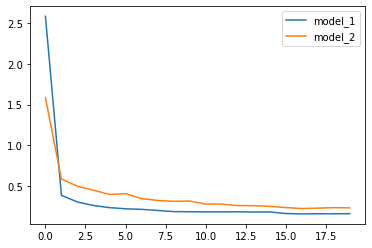

In [85]:
print('Train MAE')
plt.plot(history_1.history['mean_absolute_error'], label='model_1')
plt.plot(history_2.history['mean_absolute_error'], label='model_2')
plt.legend(loc="upper right")

Val MAE


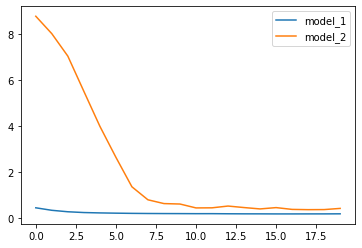

In [86]:
print('Val MAE')
plt.plot(history_1.history['val_mean_absolute_error'], label='model_1')
plt.plot(history_2.history['val_mean_absolute_error'], label='model_2')
plt.legend(loc="upper right")

In [87]:
print_metrics(model_2, data_train, name='Train')
print_metrics(model_2, data_val, name='Val');

# probably, we need a bit more epochs for model_2

Train results:
Mean square error: 0.21637
Mean absolute error: 0.39108
Val results:
Mean square error: 0.29616
Mean absolute error: 0.41774


In [ ]:
# now, let's try bidirectional LSTM

In [91]:
def build_model_3(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
      
    # <YOUR CODE>
    # Build your monster!
    
    x_title = L.Embedding(n_tokens, hid_size)(l_title)
    x_title = L.Bidirectional(L.LSTM(hid_size, input_shape=(None, None, 64)))(x_title)

    x_title = L.Dropout(0.2)(x_title)
    x_title = L.Dense(2*hid_size, activation='relu')(x_title)
    
    x_descr = L.Embedding(n_tokens, 2*hid_size)(l_descr)
    x_descr = L.Bidirectional(L.LSTM(hid_size, input_shape=(None, None, 64)))(x_descr)

    x_descr = L.Dropout(0.2)(x_descr)
    x_descr = L.Dense(2*hid_size, activation='relu')(x_descr)
    
    x_categ = L.Dense(2*hid_size, activation='relu')(l_categ)
  
    
    x = L.concatenate([x_title, x_descr, x_categ])
    
    x = L.Dense(2*hid_size, activation='relu')(x)
    x = L.Dense(hid_size, activation='relu')(x)
  
    output_layer = L.Dense(1, activation="relu")(x)
    # # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model
    

In [92]:
model_3 = build_model_3()
model_3.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
FullDescription (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, None, 64)     2170816     Title[0][0]                      
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, None, 128)    4341632     FullDescription[0][0]            
___________________________________________________________________________________________

In [93]:
dummy_pred = model_3.predict(make_batch(data_train[:100]))
dummy_loss = model_3.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [94]:
batch_size = 256
epochs = 20            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

train_mae = []
val_mae = []

model_3 = build_model_3()
build_model_2()

history_3 = model_3.fit(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,


                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

Epoch 1/20
100/100 [==============================] - 48s 411ms/step - loss: 35.1974 - mean_absolute_error: 4.2589 - val_loss: 0.2071 - val_mean_absolute_error: 0.3545
Epoch 2/20
100/100 [==============================] - 40s 400ms/step - loss: 0.2749 - mean_absolute_error: 0.4143 - val_loss: 0.4001 - val_mean_absolute_error: 0.5503
Epoch 3/20
100/100 [==============================] - 40s 396ms/step - loss: 0.1746 - mean_absolute_error: 0.3270 - val_loss: 0.5691 - val_mean_absolute_error: 0.6940
Epoch 4/20
100/100 [==============================] - 39s 395ms/step - loss: 0.1432 - mean_absolute_error: 0.2949 - val_loss: 0.4596 - val_mean_absolute_error: 0.6155
Epoch 5/20
100/100 [==============================] - 40s 397ms/step - loss: 0.1238 - mean_absolute_error: 0.2733 - val_loss: 0.5924 - val_mean_absolute_error: 0.7161
Epoch 6/20
100/100 [==============================] - 40s 405ms/step - loss: 0.1193 - mean_absolute_error: 0.2666 - val_loss: 0.5612 - val_mean_absolute_error: 0.69

In [95]:
print_metrics(model_3, data_train, name='Train')
print_metrics(model_3, data_val, name='Val');

Train results:
Mean square error: 0.22026
Mean absolute error: 0.41884
Val results:
Mean square error: 0.23706
Mean absolute error: 0.42738


OK, a small report. 
I've tried three model:
* a simple CNN; 
* CNN with batch normalizations, dropouts, poolings and couple of conv layers working on the same embeddings then concatenated;
* very basic bidirectional LSTM with default parameters. 

Trained them for 20 epochs. Here are the plots of Train MAE 

Train MAE


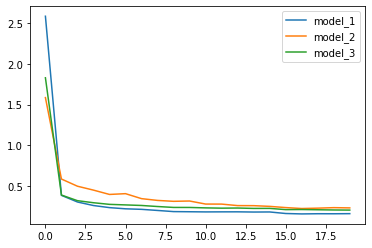

In [103]:
print('Train MAE')
plt.plot(history_1.history['mean_absolute_error'], label='model_1')
plt.plot(history_2.history['mean_absolute_error'], label='model_2')
plt.plot(history_3.history['mean_absolute_error'], label='model_3')
plt.legend(loc="upper right")

Plots for Val MAE:

Val MAE


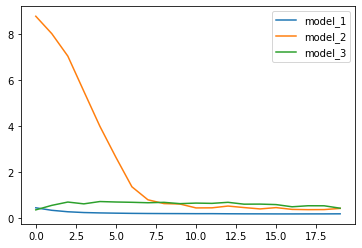

In [104]:
print('Val MAE')
plt.plot(history_1.history['val_mean_absolute_error'], label='model_1')
plt.plot(history_2.history['val_mean_absolute_error'], label='model_2')
plt.plot(history_3.history['val_mean_absolute_error'], label='model_3')
plt.legend(loc="upper right")

The results for 20 epochs show that the simplest one is better for this case. Maybe this is because I'm using not very correct LSTMs (overfitting right in this example???, using just simple LSTMs I got better results for val MAE for 20 epochs) OR possibly more epochs are needed for models_2 and models_3 as of they are more complex. Plus I'm using default parameters while hyperparameters tuning is a very important option. 

In any case - this was a very interesting exercise, playing with Keras Functional API was also very interesting.

As my first model performs better, I'm saving that one.

In [105]:
model.save('CNN_nlp.h5')